# Modelo base

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import os
from os import listdir
from os.path import isfile, join

## <font color=red>1. </font>Cargar las imágenes y los datos tabulares

In [2]:
# Resized images directory
dir_2019_images = "/kaggle/input/resizedsiimisic/train_resized/"
images_2019 = [f for f in listdir(dir_2019_images) if isfile(join(dir_2019_images, f))]

# CSV file
train_df = pd.read_csv('/kaggle/input/resizedsiimisic/train.csv')

In [3]:
train_df.head()

,image_name,sex,age_approx,anatom_site_general_challenge,target
0,ISIC_0000000.jpg,female,55.0,anterior torso,0.0
1,ISIC_0000001.jpg,female,30.0,anterior torso,0.0
2,ISIC_0000002.jpg,female,60.0,upper extremity,1.0
3,ISIC_0000003.jpg,male,30.0,upper extremity,0.0
4,ISIC_0000004.jpg,male,80.0,posterior torso,1.0


In [4]:
print("Train shape:", train_df.shape)

Train shape: (22480, 5)


## <font color=red>2. </font>Dividir conjunto de datos

In [5]:
from collections import Counter
from sklearn.model_selection import train_test_split

X = train_df
y = train_df['target']

In [6]:
# Split into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2,
                                                  stratify=y_train,
                                                  random_state=42)

print("Conjunto de train:", X_train.shape)
print("Conjunto de validacion:", X_val.shape)
print("Conjunto de prueba:", X_test.shape)
print("-----------------------")
print('Distribucion de train ->', Counter(y_train))
print('Distribucion de validacion ->', Counter(y_val))
print("Distribucion de prueba ->", Counter(y_test))

Conjunto de train: (14387, 5)
Conjunto de validacion: (3597, 5)
Conjunto de prueba: (4496, 5)
-----------------------
Distribucion de train -> Counter({0.0: 11605, 1.0: 2782})
Distribucion de validacion -> Counter({0.0: 2902, 1.0: 695})
Distribucion de prueba -> Counter({0.0: 3627, 1.0: 869})


In [7]:
X_train["target"] = X_train['target'].astype(str)
X_val["target"] = X_val['target'].astype(str)
X_test["target"] = X_test['target'].astype(str)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## <font color=red>3. </font>Crear y entrenar el modelo

In [8]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121 # input size 224x224
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model

2021-11-24 22:48:56.114776: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [9]:
datagen = ImageDataGenerator(rescale=1./255.)

train_generator = datagen.flow_from_dataframe(
    dataframe=X_train,
    directory=dir_2019_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="binary"
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=X_val,
    directory=dir_2019_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="binary"
)

test_generator = datagen.flow_from_dataframe(
    dataframe=X_test,
    directory=dir_2019_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="binary"
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

Found 14387 validated image filenames belonging to 2 classes.
Found 3597 validated image filenames belonging to 2 classes.
Found 4496 validated image filenames belonging to 2 classes.


In [10]:
encoder = DenseNet121(input_shape=(None,None,3), 
                      include_top=False, 
                      weights='imagenet')

2021-11-24 22:49:06.552806: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-24 22:49:06.555833: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-24 22:49:06.603989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 22:49:06.604621: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-11-24 22:49:06.604690: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-11-24 22:49:06.654710: I tensorflow/stream_executor/platform/def

29089792/29084464 [==============================] - 0s 0us/step


In [11]:
# for layer in encoder.layers:
#    layer.trainable = False

inputs = Input(shape=(None, None, 3))
x = encoder(inputs, training=False)
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=predictions)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [13]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'),
      AUC(name='auc')
]

In [14]:
checkpoint_filepath = '/kaggle/working/base_model.h5'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            monitor='val_auc',
                                            mode='max',
                                            verbose=1,
                                            save_best_only=True)

In [15]:
model.compile(
    optimizer=Adam(),
    loss=BinaryCrossentropy(),
    metrics=METRICS
)

In [16]:
history = model.fit(train_generator,  
                    validation_data =valid_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN, 
                    validation_steps=STEP_SIZE_VALID,
                    callbacks=[model_checkpoint_callback],
                    epochs = 100)

2021-11-24 22:49:13.020052: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-24 22:49:13.024313: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000179999 Hz


Epoch 1/100


2021-11-24 22:49:24.185324: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-11-24 22:49:25.031991: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-11-24 22:49:25.098184: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


449/449 [==============================] - 163s 321ms/step - loss: 0.9029 - tp: 11.0378 - fp: 46.8267 - tn: 5741.2756 - fn: 1411.4156 - auc: 0.5146 - val_loss: 0.4974 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2890.0000 - val_fn: 694.0000 - val_auc: 0.6566

Epoch 00001: val_auc improved from -inf to 0.65657, saving model to /kaggle/working/base_model.h5
Epoch 2/100
449/449 [==============================] - 136s 303ms/step - loss: 0.4687 - tp: 6.9600 - fp: 12.8756 - tn: 5815.7111 - fn: 1376.1356 - auc: 0.6516 - val_loss: 0.4476 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2891.0000 - val_fn: 693.0000 - val_auc: 0.7261

Epoch 00002: val_auc improved from 0.65657 to 0.72613, saving model to /kaggle/working/base_model.h5
Epoch 3/100
449/449 [==============================] - 135s 301ms/step - loss: 0.4335 - tp: 82.0333 - fp: 56.7578 - tn: 5768.0822 - fn: 1299.8111 - auc: 0.7285 - val_loss: 0.4243 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 2891.0000 - val_fn: 692.0000 

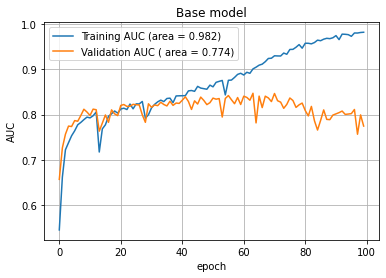

In [17]:
plt.plot(history.history['auc'], 
         label='Training AUC (area = {:.3f})'.format(history.history['auc'][-1]))
plt.plot(history.history['val_auc'], 
         label='Validation AUC ( area = {:.3f})'.format(history.history['val_auc'][-1]))
plt.title('Base model')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.grid()
plt.legend(loc='best')

plt.show()

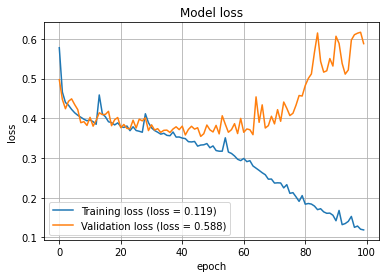

In [18]:
plt.plot(history.history['loss'], label='Training loss (loss = {:.3f})'.format(history.history['loss'][-1]))
plt.plot(history.history['val_loss'], label='Validation loss (loss = {:.3f})'.format(history.history['val_loss'][-1]))
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(loc='best')

plt.show()

## <font color=red>4. </font>Evaluar el modelo

In [19]:
eval_metrics = model.evaluate(test_generator, 
                              steps=STEP_SIZE_TEST,
                              return_dict=True,
                              use_multiprocessing=False,
                              verbose=1)

140/140 [==============================] - 29s 210ms/step - loss: 0.6546 - tp: 331.0000 - fp: 268.0000 - tn: 3345.0000 - fn: 536.0000 - auc: 0.7453


#### Se obtiene las predicciones y las etiquetas del conjunto de prueba.

In [20]:
true_labels = test_generator.classes
predict = model.predict(test_generator,
                        verbose=1)

141/141 [==============================] - 14s 91ms/step


#### Finalmente, se observa la curva ROC-AUC y la matriz de confusión.

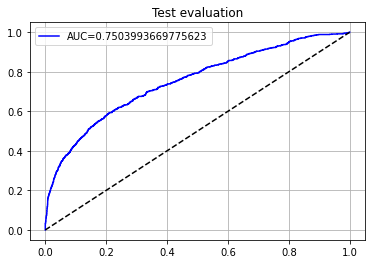

In [21]:
from sklearn import metrics

fpr, tpr, tr = metrics.roc_curve(true_labels, predict)
auc = metrics.roc_auc_score(true_labels, predict)
plt.plot(fpr,tpr,'b',label="AUC="+str(auc))
plt.plot([0,1],[0,1],'k--')
plt.title('Test evaluation')
plt.grid()
plt.legend(loc='best')
plt.show()

<AxesSubplot:>

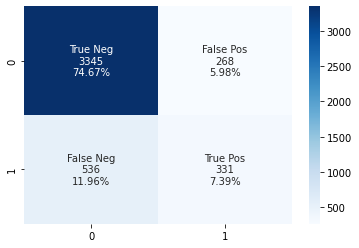

In [22]:
import seaborn as sns

cm = [eval_metrics['tn'], eval_metrics['fp'], eval_metrics['fn'], eval_metrics['tp']]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm]
group_percentages = ["{0:.2%}".format(value) for value in cm/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap([[cm[0], cm[1]], [cm[2], cm[3]]], annot=labels, fmt='', cmap='Blues')